# Variational Quantum EigenSolver

In [1]:
import numpy as np
import pylab

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


## 1.  Basic VQE Calculation
### 1.1 Importing basic libraries and standard Qiskit libraries

In [3]:
import numpy as np
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.providers.aer import StatevectorSimulator
from qiskit.utils import QuantumInstance
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.providers.ibmq import least_busy
from qiskit.circuit.library import TwoLocal

1.2 Importing Qiskit Nature librarires for quantum chemistry simulation

In [4]:
#Importing Qiskit Librarires for VQE
from qiskit.algorithms import NumPyMinimumEigensolver, VQE
from qiskit.algorithms.optimizers import COBYLA, SLSQP, L_BFGS_B, SPSA

In [5]:
#Import Qiskit Nature Libararies
from qiskit_nature.settings import settings
from qiskit_nature.drivers import UnitsType, Molecule
from qiskit_nature.drivers.second_quantization import PySCFDriver
from qiskit_nature.problems.second_quantization.electronic import ElectronicStructureProblem
from qiskit_nature.converters.second_quantization import QubitConverter 
from qiskit_nature.mappers.second_quantization import JordanWignerMapper, ParityMapper, BravyiKitaevMapper
#from qiskit_nature.transformers import ActiveSpaceTransformer #ActiveSpaceTransformer Missing
from qiskit_nature.algorithms import VQEUCCFactory, GroundStateEigensolver
from qiskit_nature.circuit.library import HartreeFock, UCCSD, PUCCD
settings.dict_aux_operators =True

### 1.3 Setting up the molecule

In [6]:
molecule = Molecule(geometry=[['H',[0.,0.,0.]],['H',[0.,0.,0.735]]],charge=0,multiplicity=1)

### 1.4 Initiating the PySCF driver(for setup of quantum chemical calculations and Hartree-fock Calculation)

In [7]:
import pyscf
driver = PySCFDriver(unit=UnitsType.ANGSTROM, basis='sto3g')

In [9]:
#Performing the setup calculation using PySCF and retrieve data from the calculations
es_problem = ElectronicStructureProblem(driver)
#Getting the second quantized Hamiltonian
second_q_op = es_problem.second_q_ops()
print(type(second_q_op))
print(second_q_op['ParticleNumber'])

<class 'dict'>
Fermionic Operator
register length=4, number terms=4
  (1+0j) * ( +_0 -_0 )
+ (1+0j) * ( +_1 -_1 )
+ (1+0j) * ( +_2 -_2 )
+ (1+0j) * ( +_3 -_3 )


In [ ]:
#num_particles=(es_problem.molecule_data_transformed.num_alpha,
#               es_problem.molecule_data_transformed.num_beta)
#num_spin_orbitals = 2* es_problem.molceule_data.num_molecular_orbitals

### 1.5 Transfrom the Hamiltonian into qubitized form

In [10]:
qubit_converter= QubitConverter(mapper=JordanWignerMapper())
qubit_op= qubit_converter.convert(second_q_op['ParticleNumber'])
print(qubit_op) 

#Bravyi Kitaev Mapping
qubit_converter = QubitConverter(mapper=BravyiKitaevMapper())
qubit_op = qubit_converter.convert(second_q_op['ParticleNumber'])
print(qubit_op)

2.0 * IIII
- 0.5 * IIIZ
- 0.5 * IIZI
- 0.5 * IZII
- 0.5 * ZIII
2.0 * IIII
- 0.5 * IIIZ
- 0.5 * IIZZ
- 0.5 * IZII
- 0.5 * ZZZI


In the minimal STO-3G basis set 4 qubits are required. We can reduce the number of qubits by using the Parity Mapping, which allows for the removal of 2 qubits by exploiting known symmetries arising from the mapping

### 1.6 Comparison with two qubit reduction

In [11]:
qubit_converter2= QubitConverter(mapper = ParityMapper(), two_qubit_reduction=True)
#If two_qubit_reduction is assigned as False, the number of terms will same as that of JW and BK Mapping
qubit_op2 = qubit_converter2.convert(second_q_op[0], num_particles=es_problem.num_particles)
print(qubit_op2)

Traceback (most recent call last):
  Input In [11] in <cell line: 3>
    qubit_op2 = qubit_converter2.convert(second_q_op[0], num_particles=es_problem.num_particles)
KeyError: 0

Use %tb to get the full traceback.


In [12]:
#Set the solver for the exact value
numpy_solver = NumPyMinimumEigensolver()

### 1.7 Performing reference calculation

In [13]:
calc = GroundStateEigensolver(qubit_converter, numpy_solver)
res= calc.solve(es_problem)
print(res)

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -1.857275030202
  - computed part:      -1.857275030202
~ Nuclear repulsion energy (Hartree): 0.719968994449
> Total ground state energy (Hartree): -1.137306035753
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  1.3889487]
 
  0: 
  * Electronic dipole moment (a.u.): [0.0  0.0  1.3889487]
    - computed part:      [0.0  0.0  1.3889487]
  > Dipole moment (a.u.): [0.0  0.0  0.0]  Total: 0.0
                 (debye): [0.0  0.0  0.0]  Total: 0.0
 


### 1.8 Setting up for the VQE Calculation

In [14]:
#Setting the optimizer(COBYLA, L_BFGS_B (L-BFGS-B), and etc.)
optimizer = SLSQP(maxiter=100)

#Setting the number of basis set and the number of particles
num_spin_orbitals=4
num_particles=(1,1)

#Setting the intial state as the HF State 1100 or 1010 in Qiskit Convention
initial_state = HartreeFock(num_spin_orbitals, num_particles, qubit_converter)

#Set the UCCSD Ansatz
ansatz = UCCSD(qubit_converter, num_particles, num_spin_orbitals, initial_state=initial_state)

#Set the VQE Solver
vqe_solver = VQE(ansatz = ansatz, optimizer = optimizer, quantum_instance=QuantumInstance(backend=Aer.get_backend("statevector_simulator")))

### 1.9 Perform the VQE calculation using GroundStateEigensolver

In [15]:
from qiskit_nature.algorithms import GroundStateEigensolver
#Perform the VQE Calculation using the Ground State EigenSolver
calc = GroundStateEigensolver(qubit_converter, vqe_solver)
res = calc.solve(es_problem)
print(res)

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -1.857275030144
  - computed part:      -1.857275030144
~ Nuclear repulsion energy (Hartree): 0.719968994449
> Total ground state energy (Hartree): -1.137306035695
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  1.3889487]
 
  0: 
  * Electronic dipole moment (a.u.): [0.0  0.0  1.38894843]
    - computed part:      [0.0  0.0  1.38894843]
  > Dipole moment (a.u.): [0.0  0.0  0.00000027]  Total: 0.00000027
                 (debye): [0.0  0.0  0.00000068]  Total: 0.00000068
 


## 2. Constructing a PE Curve

### 2.1 Calculating the molecular energy while elongating H-H bond length

In [17]:
h2_length = np.arange(0.5,3,0.1)
hf_energy_list=[]
uccsd_energy_list=[]
for bond_length in h2_length:
    molecule = Molecule(geometry=[['H',[0.,0., 0.]],['H',[0.,0.,bond_length]]], charge=0, multiplicity=1)
    driver = PySCFDriver(atom='H 0.0 0.0 0.0; H 0.0 0.0 '+str(bond_length), unit=UnitsType.ANGSTROM, basis='sto3g')
    es_problem = ElectronicStructureProblem(driver)
    qubit_converter = QubitConverter(mapper = ParityMapper(), two_qubit_reduction=True)
    quantum_instance = QuantumInstance(backend =Aer.get_backend('statevector_simulator'))
    vqe_solver = VQEUCCFactory(quantum_instance)
    calc = GroundStateEigensolver(qubit_converter, vqe_solver)
    res = calc.solve(es_problem)
    #VQEUCCFactory.get_solver(es_problem, qubit_converter)
    hf_energy_list += [res.hartree_fock_energy]
    uccsd_energy_list += [res.total_energies[0]]
print (hf_energy_list)


/tmp/ipykernel_59/930572060.py:10: DeprecationWarning: VQEUCCFactory Constructor: quantum_instance is no longer a positional argument as of version 0.4 and will be removed no sooner than 3 months after the release. Instead use it as a keyword argument
  vqe_solver = VQEUCCFactory(quantum_instance)


[-1.042996274540095, -1.1011282422677018, -1.11734903499028, -1.1108503974765953, -1.0919140410200567, -1.0661086493179364, -1.03653887502918, -1.0051067065684898, -0.9731106157775782, -0.9414806547077987, -0.9108735545943863, -0.8817324499460566, -0.8543376269512921, -0.8288481479269776, -0.8053328448932777, -0.7837926542773531, -0.7641776516167976, -0.746401349991159, -0.7303533213548867, -0.7159100604538069, -0.7029435997235272, -0.691327561197378, -0.6809407606225897, -0.671668859751728, -0.6634047415990407]


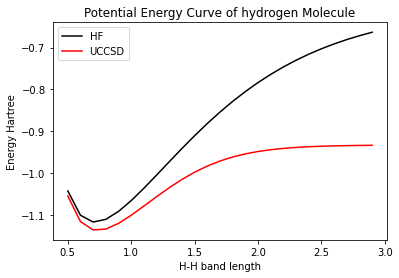

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(h2_length, hf_energy_list, color='black', label='HF')
plt.plot(h2_length, uccsd_energy_list, color='red', label='UCCSD')
plt.title("Potential Energy Curve of hydrogen Molecule")
plt.xlabel("H-H band length")
plt.ylabel("Energy Hartree")
plt.legend()